# This notebook is for detecting single eye blinks in the data

In [1]:
import sys
sys.path.append('../')

import config
config.reset_filter_states()
import filters as f
import numpy as np
import torch
import os
import pickle
from pathlib import Path

In [2]:
t = Path('../test_data/')
files = os.listdir('../test_data/')

In [3]:
eyeBlinkFiles = []
for file in files:
    if('test' in file):
        eyeBlinkFiles.append(file)

In [4]:
eyeBlinkFiles

['[f]test1091019_205648.pickle']

In [5]:
eyeBlinkFiles.sort()
fi = open(t/eyeBlinkFiles[-1],'rb')
d = pickle.load(fi)
d.shape

(20, 8, 250)

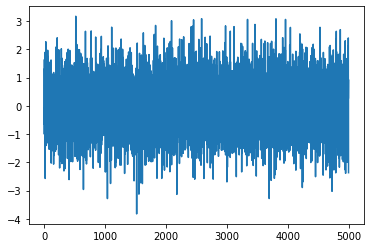

In [7]:
import matplotlib.pyplot as plt
plt.plot(d[:,0,:].reshape(-1))
plt.show()

In [ ]:
data = np.zeros((1,8,250))
config.reset_filter_states()
for file in eyeBlinkFiles:
    with open('../test_data/'+file,'rb') as ef:
        d = pickle.load(ef)
        print(d.shape)
        d = f.apply_bandpass_filter(d,3,7)
        d = d[4:]
        data = np.vstack((data,d))
data = data[1:]

In [ ]:
data.shape

In [ ]:
146/4

In [ ]:
labels = np.array([1,0,0,0]*(int(data.shape[0]/4)))

In [ ]:
labels.shape

# Testing out keras

In [ ]:
import keras
from keras.layers import Convolution2D, Input, MaxPool2D, AvgPool2D,Dense,Flatten, BatchNormalization
from keras.models import Model
from keras.utils import np_utils

In [ ]:
inp = Input(shape=(1,250,1))
l1 = Convolution2D(32,(1,3),activation='relu',input_shape=(1,250))(inp) # 248
l2 = Convolution2D(64,(1,3),activation='relu')(l1) # 246
#bn1 = BatchNormalization()(l2)
p1 = MaxPool2D((1,2))(l2) # 123
l3 = Convolution2D(32,(1,3),activation='relu')(p1) # 121
l4 = Convolution2D(64,(1,3),activation='relu')(l3) # 119
#bn2 = BatchNormalization()(l4)
p2 = MaxPool2D((1,2))(l4) # 59
l5 = Convolution2D(32,(1,3),activation='relu')(p2) # 57
l6 = Convolution2D(64,(1,3),activation='relu')(l5) # 55
#bn3 = BatchNormalization()(l6)
p3 = MaxPool2D((1,2))(l6) # 27
l7 = Convolution2D(32,(1,3),activation='relu')(p3) # 25
l8 = Convolution2D(64,(1,3),activation='relu')(l7) # 23
#bn4 = BatchNormalization()(l8)
p4 = MaxPool2D((1,2))(l8) # 11
l9 = Convolution2D(32,(1,3),activation='relu')(p4) # 9 
lX = Convolution2D(64,(1,3),activation='relu')(l9) # 7
ap = AvgPool2D((1,7))(lX) # 1
flat = Flatten()(ap)
d1 = Dense(2,activation='softmax')(flat)
model = Model(inputs=inp,outputs=d1)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
#np.random.seed(42)
chan_0 = data[:,[0],:]
chan_0 = np.expand_dims(chan_0,axis=-1)
x_data = chan_0/200.0
y_data = np_utils.to_categorical(labels)
from sklearn.model_selection import train_test_split
X,x,Y,y = train_test_split(x_data,y_data,test_size=0.2,random_state=0)
#X = (X - X.mean())/X.std()
#x = (x - X.mean())/X.std()

In [ ]:
model.fit(X,Y,epochs=10,batch_size=16,validation_data=(x,y),shuffle=True)

In [ ]:
out = model.predict(x)

predicted_labels = out.argmax(axis=-1)

real_labels = y.argmax(axis=-1)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predicted_labels,real_labels)

cm

# Plotting wrong labels

In [ ]:
# First get wrong predicted labels
wrong = (predicted_labels == real_labels)
np.where(wrong == False)

In [ ]:
wrong_idx = np.where(wrong==False)
wrong_idx[0]

In [ ]:
wrong_data = x[wrong_idx[0]]

In [ ]:
print(wrong_data.shape)
wrong_data = np.squeeze(wrong_data)
print(wrong_data.shape)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(wrong_data.shape[0],1,figsize=(10,15))
if(type(ax) != np.ndarray):
    ax = np.array([ax])
lab = {0:'No Blink',1:'Blink'}
for i in range(wrong_data.shape[0]):
    ax[i].plot(wrong_data[i])
    ax[i].set_title(f'real: {lab[real_labels[wrong_idx[0][i]]]}, pred:{lab[predicted_labels[wrong_idx[0][i]]]}')
    ax[i].set_ylim(-1,1)
plt.show()

# Hoow classification matrix works

In [ ]:
x = [0,1,0,1,0,0]
y = [0,1,0,1,1,0]

In [ ]:
cm = confusion_matrix(x,y)

In [ ]:
cm